# Data Exploratory Analysis

#### Resolving Dependencies

In [ ]:
%pip install datasets
%pip install torch torchvision torchaudio
%pip install transformers
%pip install faiss-cpu faiss-gpu   # faiss-gpu if using GPU
%pip install Pillow numpy scikit-learn
%pip install git+https://github.com/facebookresearch/segment-anything.git  # Optional for segmentation
%pip install --upgrade peft
%pip install --upgrade transformers peft

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 47.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.3
    Uninstalling transformers-4.52.3:
      Successfully uninstalled transformers-4.52.3

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!mkdir flickr30k && cd flickr30k
# Download the Flickr30k dataset
!wget http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip
!tar -xvzf Flickr8k_Dataset.zip

# Download the Flickr30k annotations
!wget http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_text.zip
!tar -xvzf Flickr8k_text.zip

mkdir: cannot create directory ‘flickr30k’: File exists


--2025-06-02 19:20:24--  http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip
Resolving nlp.cs.illinois.edu (nlp.cs.illinois.edu)... 18.220.149.166
Connecting to nlp.cs.illinois.edu (nlp.cs.illinois.edu)|18.220.149.166|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-06-02 19:20:24 ERROR 404: Not Found.

tar (child): Flickr8k_Dataset.zip: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
--2025-06-02 19:20:25--  http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_text.zip
Resolving nlp.cs.illinois.edu (nlp.cs.illinois.edu)... 18.220.149.166
Connecting to nlp.cs.illinois.edu (nlp.cs.illinois.edu)|18.220.149.166|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-06-02 19:20:25 ERROR 404: Not Found.

tar (child): Flickr8k_text.zip: Cannot open: No such file or d

#### Importing Libraries

In [1]:
import gc
import torch
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import faiss
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import PIL.Image as Image
import glob
import pickle
import numpy as np
from peft import get_peft_model, LoraConfig, TaskType

/bigdata/chaturvedilab/shared/EvoCell/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load flickr30k dataset
ds = load_dataset("nlphuji/flickr30k", cache_dir="./.hf_cache", data_dir=".")
# train_data = ds["test"]
train_data = ds["test"].select(range(4000))  # Just 4000 images for now

In [3]:
# Basic PyTorch-style DataLoader
def collate_fn(batch):
    images = [sample["image"] for sample in batch]
    texts = [sample["caption"][0] for sample in batch]  # use first caption TODO: handle multiple captions
    paths = [sample["filename"] for sample in batch]    # get filenames here
    return images, texts, paths

loader = DataLoader(train_data, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model_name = "openai/clip-vit-base-patch32"
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)
clip_model = CLIPModel.from_pretrained(clip_model_name, cache_dir="./.cache", trust_remote_code=True, use_safetensors=True).to(DEVICE)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
print(ds["test"][0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500 at 0x7F56D53D8D30>, 'caption': ['Two young guys with shaggy hair look at their hands while hanging out in the yard.', 'Two young, White males are outside near many bushes.', 'Two men in green shirts are standing in a yard.', 'A man in a blue shirt standing in a garden.', 'Two friends enjoy time spent together.'], 'sentids': ['0', '1', '2', '3', '4'], 'split': 'train', 'img_id': '0', 'filename': '1000092795.jpg'}


1000092795.jpg


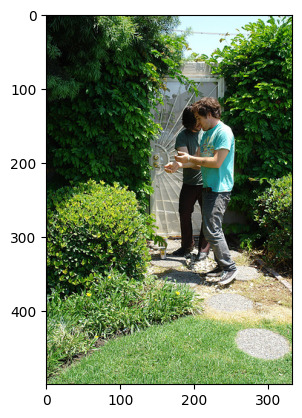

In [6]:
# Display the first image in the dataset using PIL
images, texts, paths = next(iter(loader))
print(paths[0]) # Display the first image
plt.imshow(images[0])

### Image Embedding Generation & Storing

In [7]:
import os
import pickle
import gc
import glob
import faiss
import numpy as np
import torch
from tqdm import tqdm

def create_image_embeddings(
    model,
    processor,
    dataloader,
    save_dir="./image_chunks",
    chunk_size=2000,
    normalize=True,
    save_images=False,
    image_save_dir="./saved-images"
):
    os.makedirs(save_dir, exist_ok=True)
    if save_images:
        os.makedirs(image_save_dir, exist_ok=True)

    chunk_id = 0
    image_embeddings = []
    text_data_chunk = []
    image_paths_chunk = []

    all_texts = []
    all_paths = []
    chunk_paths = []

    print("📦 Encoding image embeddings and saving chunks...")

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Encoding"):
            images, texts, filenames = batch

            for image, text, filename in zip(images, texts, filenames):
                try:
                    # Save image to disk (optional)
                    full_path = os.path.join(image_save_dir, filename) if save_images else filename
                    if save_images and not os.path.exists(full_path):
                        image.save(full_path)

                    # Generate embedding
                    inputs = processor(images=image, return_tensors="pt")
                    inputs = {k: v.to(model.device) for k, v in inputs.items()}
                    img_embed = model.get_image_features(**inputs)

                    # Append current data
                    image_embeddings.append(img_embed.cpu().numpy())
                    text_data_chunk.append(text)
                    image_paths_chunk.append(full_path)

                    all_texts.append(text)
                    all_paths.append(full_path)

                    del inputs, img_embed
                    torch.cuda.empty_cache()
                    gc.collect()

                except Exception as e:
                    print(f"❌ Error processing {filename}: {e}")
                    continue

                # Save chunk if full
                if len(image_embeddings) >= chunk_size:
                    emb_np = np.concatenate(image_embeddings, axis=0).astype("float32")
                    if normalize:
                        faiss.normalize_L2(emb_np)

                    emb_path = os.path.join(save_dir, f"embeddings_chunk_{chunk_id}.npy")
                    meta_path = os.path.join(save_dir, f"metadata_chunk_{chunk_id}.pkl")

                    np.save(emb_path, emb_np)
                    with open(meta_path, "wb") as f:
                        pickle.dump({"texts": text_data_chunk, "paths": image_paths_chunk}, f)

                    print(f"💾 Saved chunk {chunk_id} with {len(emb_np)} embeddings")
                    chunk_paths.append(emb_path)

                    # Reset for next chunk
                    image_embeddings = []
                    text_data_chunk = []
                    image_paths_chunk = []
                    chunk_id += 1

        # Save remaining data
        if image_embeddings:
            emb_np = np.concatenate(image_embeddings, axis=0).astype("float32")
            if normalize:
                faiss.normalize_L2(emb_np)

            emb_path = os.path.join(save_dir, f"embeddings_chunk_{chunk_id}.npy")
            meta_path = os.path.join(save_dir, f"metadata_chunk_{chunk_id}.pkl")

            np.save(emb_path, emb_np)
            with open(meta_path, "wb") as f:
                pickle.dump({"texts": text_data_chunk, "paths": image_paths_chunk}, f)

            print(f"💾 Saved final chunk {chunk_id} with {len(emb_np)} embeddings")
            chunk_paths.append(emb_path)

    print("✅ All chunks processed and saved.")
    return all_texts, all_paths, chunk_paths

In [8]:
image_save_dir = "/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images"
embedding_save_dir = "/rhome/abhar061/shared/adv_ml/project/image_chunks"
clip_texts, clip_paths, clip_files = create_image_embeddings(
    model=clip_model,
    processor=clip_processor,
    dataloader=loader,
    save_dir=embedding_save_dir,
    chunk_size=2048,
    normalize=True,
    save_images=True,
    image_save_dir=image_save_dir,
)

📦 Encoding image embeddings and saving chunks...


Encoding:  51%|█████     | 128/250 [05:11<04:54,  2.42s/it]

💾 Saved chunk 0 with 2048 embeddings


Encoding: 100%|██████████| 250/250 [10:04<00:00,  2.42s/it]

💾 Saved final chunk 1 with 1952 embeddings
✅ All chunks processed and saved.


### Loading embeddings, images & queries

In [9]:
import os
import glob
import pickle
import numpy as np
import faiss

def load_image_embeddings_from_chunks(chunk_dir="./image_chunks"):
    """
    Load image embeddings, text descriptions, and image paths from saved FAISS chunks.

    Args:
        chunk_dir (str): Directory where chunked embeddings and metadata are stored.

    Returns:
        tuple:
            - image_embeddings (np.ndarray): Array of image embeddings.
            - text_data (List[str]): List of text captions.
            - image_paths (List[str]): List of image file paths.
    """
    text_data = []
    image_paths = []

    metadata_files = sorted(glob.glob(os.path.join(chunk_dir, "metadata_chunk_*.pkl")))
    if not metadata_files:
        raise FileNotFoundError(f"❌ No metadata files found in {chunk_dir}")

    for meta_file in metadata_files:
        with open(meta_file, "rb") as f:
            meta = pickle.load(f)
            text_data.extend(meta["texts"])
            image_paths.extend(meta["paths"])

    embedding_files = sorted(glob.glob(os.path.join(chunk_dir, "embeddings_chunk_*.npy")))
    if not embedding_files:
        raise FileNotFoundError(f"❌ No embedding files found in {chunk_dir}")

    all_embeddings = []
    for emb_file in embedding_files:
        emb_chunk = np.load(emb_file)
        all_embeddings.append(emb_chunk)

    image_embeddings = np.concatenate(all_embeddings, axis=0).astype("float32")

    print(f"📦 Loaded {len(text_data)} texts")
    print(f"🖼️ Loaded {len(image_paths)} image paths")
    print(f"📊 Loaded {image_embeddings.shape[0]} embeddings of dim {image_embeddings.shape[1]}")

    assert len(text_data) == len(image_paths) == image_embeddings.shape[0], \
        "❌ Mismatch: Number of texts, image paths, and embeddings must be equal!"

    return image_embeddings, text_data, image_paths

In [10]:
clip_dir = "./image_chunks"
clip_image_embeddings, clip_text_data, clip_image_paths = load_image_embeddings_from_chunks(clip_dir)

📦 Loaded 4000 texts
🖼️ Loaded 4000 image paths
📊 Loaded 4000 embeddings of dim 512


### Building Faiss Index

In [11]:
import os
import faiss
import numpy as np

def build_or_load_faiss_index(
    embeddings: np.ndarray,
    index_path: str = None,
    normalize: bool = True
):
    """
    Build a FAISS index from embeddings or load from disk if `index_path` exists.

    Args:
        embeddings (np.ndarray): Array of shape (n_samples, embedding_dim), must be float32.
        index_path (str): Optional path to save/load the FAISS index.
        normalize (bool): Whether to L2 normalize the embeddings before indexing.

    Returns:
        faiss.Index: FAISS index (IndexFlatIP).
    """
    assert isinstance(embeddings, np.ndarray), "embeddings must be a NumPy array"
    assert len(embeddings.shape) == 2, "embeddings must be 2D"
    assert embeddings.dtype == np.float32, "embeddings must be float32"

    if index_path and os.path.exists(index_path):
        print(f"📂 Loading FAISS index from: {index_path}")
        index = faiss.read_index(index_path)
        return index

    if normalize:
        faiss.normalize_L2(embeddings)

    dim = embeddings.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(embeddings)

    print(f"✅ FAISS index built: {index.ntotal} vectors, dim {dim}")

    if index_path:
        faiss.write_index(index, index_path)
        print(f"💾 Index saved to: {index_path}")

    return index

In [12]:
# Build or load index
index_dir = "./faiss_index/"
clip_index_file = os.path.join(index_dir, "clip.index")

# Creating directory if it doesn't exist
if not os.path.exists(index_dir):
    os.makedirs(index_dir)

# Creating or loading the FAISS index for CLIP embeddings
clip_index = build_or_load_faiss_index(
    embeddings=clip_image_embeddings,
    index_path=clip_index_file,  # auto-creates if doesn't exist
    normalize=True
)

📂 Loading FAISS index from: ./faiss_index/clip.index


In [13]:
from PIL import Image
import torch
import faiss
import os

def retrieve_similar_images(image_query, model, index, text_data, image_paths, top_k=5):
    """
    Retrieves top_k most similar images (from indexed dataset) to the given image query.
    
    Parameters:
        image_query (str or PIL.Image.Image): The input query image (path or object).
        model (CLIPModel): Pretrained CLIP model or lora adaptation of it for encoding images.
        index (faiss.Index): FAISS index containing image embeddings.
        text_data (list): List of text captions corresponding to indexed images.
        image_paths (list): List of image file paths corresponding to indexed images.
        top_k (int): Number of similar results to retrieve.
    """
    # Load image from path if necessary
    if isinstance(image_query, str):
        if not os.path.exists(image_query):
            print(f"❌ Image path does not exist: {image_query}")
            return
        image = Image.open(image_query).convert("RGB")
    elif isinstance(image_query, Image.Image):
        image = image_query
    else:
        print("❌ Invalid image input: must be PIL.Image or valid path.")
        return

    # Preprocess and encode
    inputs = clip_processor(images=image, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        query_emb = model.get_image_features(**inputs)
    query_emb = query_emb.cpu().numpy().astype("float32")
    faiss.normalize_L2(query_emb)

    # Search FAISS index
    scores, indices = index.search(query_emb, top_k)
    print(f"\n🔍 Image Query Results (Top {top_k}):\n")

    for i, idx in enumerate(indices[0]):
        if idx < len(text_data) and idx < len(image_paths):
            print(f"Rank {i+1}:")
            print(f"   Caption: {text_data[idx]}")
            print(f"   Path   : {image_paths[idx]}")
        else:
            print(f"Rank {i+1}: [Index {idx} out of bounds]")

    return indices  # Return the indices for optional downstream use

In [14]:
def retrieve_images_by_text_return_indices(text_query, index, image_paths, text_data, clip_model=clip_model, top_k=5):
    """
    Retrieves indices of images most relevant to the given text query using CLIP + FAISS.

    Parameters:
        text_query (str): Text to search with.
        index (faiss.Index): FAISS index for searching.
        image_paths (List[str]): List of image file paths corresponding to the indexed images which are stored locally.
        text_data (List[str]): List of text captions corresponding to the indexed images.
        clip_model (CLIPModel): Pretrained CLIP model or lora adaptation of it for encoding text.
        top_k (int): Number of top results to return.

    Returns:
        List[List[int]]: A 2D list of valid indices (like FAISS returns).
    """
    # Tokenize and encode text
    inputs = clip_processor(text=[text_query], return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        text_emb = clip_model.get_text_features(**inputs)
    text_emb = text_emb.cpu().numpy().astype("float32")
    faiss.normalize_L2(text_emb)

    # Search FAISS index
    scores, indices = index.search(text_emb, top_k * 5)  # Retrieve more to filter invalid ones

    print(f"\n🔍 Text Query Results for: \"{text_query}\"\n")

    valid_indices = []
    for i, idx in enumerate(indices[0]):
        if idx < len(text_data) and idx < len(image_paths) and os.path.exists(image_paths[idx]):
            print(f"Rank {len(valid_indices)+1}:")
            print(f"   Caption: {text_data[idx]}")
            print(f"   Path   : {image_paths[idx]}")
            valid_indices.append(idx)
            if len(valid_indices) >= top_k:
                break
        else:
            print(f"⚠️ Rank {i+1}: [Index {idx} out of bounds or missing image path]")

    if not valid_indices:
        print("❌ No valid results found for the text query.")

    return [valid_indices]  # Keep 2D shape for compatibility

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import textwrap
import math

def display_retrieved_images_from_paths(
    indices, image_paths, labels, query_image_path=None, query_label=None, num_images=5
):
    """
    Display the query image (if provided) and top-k retrieved images with their labels/descriptions in a grid layout.

    Parameters:
        indices (List[List[int]]): 2D list of indices (FAISS-style)
        image_paths (List[str]): List of all image file paths
        labels (List[str]): List of labels/descriptions corresponding to each image path
        query_image_path (str): Optional path to the query image
        query_label (str): Optional label/description for the query image
        num_images (int): Number of images to attempt to display
    """

    # Display the query image if path is provided and valid
    if query_image_path and os.path.exists(query_image_path):
        try:
            query_img = Image.open(query_image_path).convert("RGB")
            plt.figure(figsize=(5, 5))
            plt.imshow(query_img)
            plt.axis('off')
            title = "Query Image"
            if query_label:
                title += f"\nLabel: {query_label}"
            plt.title(title, fontsize=12)
            plt.show()
        except Exception as e:
            print(f"❌ Error loading query image: {e}")
    else:
        if query_label:
            print(f"\n📝 Query (text-only): {query_label}")
        else:
            print("⚠️ No query image or label provided.\n")

    # Display retrieved images in a grid
    retrieved = indices[0]
    num_to_display = min(num_images, len(retrieved))

    n_cols = min(3, num_to_display)
    n_rows = math.ceil(num_to_display / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten() if num_to_display > 1 else [axes]

    for i in range(n_rows * n_cols):
        if i < num_to_display:
            idx = retrieved[i]
            if idx < len(image_paths) and os.path.exists(image_paths[idx]):
                try:
                    img = Image.open(image_paths[idx]).convert("RGB")
                    axes[i].imshow(img)
                    label = labels[idx] if idx < len(labels) else "No label"
                    wrapped_label = "\n".join(textwrap.wrap(label, width=40))
                    axes[i].set_title(f"Rank {i+1}\n{wrapped_label}", fontsize=10)
                except Exception as e:
                    print(f"❌ Error loading image at {image_paths[idx]}: {e}")
                    axes[i].set_title(f"Error: {e}")
            else:
                print(f"⚠️ Skipping invalid or missing path at index {idx}")
                axes[i].set_title("Missing image")
            axes[i].axis('off')
        else:
            axes[i].axis('off')  # Hide unused subplots

    plt.tight_layout()
    plt.show()

# Retrieval System using CLIP

### Image from Text Retrieval


🔍 Text Query Results for: "A birthday cake with candles"

Rank 1:
   Caption: A birthday celebration taking place for a girl who has reached age 5.
   Path   : /rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1271210445.jpg
Rank 2:
   Caption: Two women attempt to blow out the candles of a multicolored, multi-tiered cake while a third woman holds a candle up in the air.
   Path   : /rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/2147876139.jpg
Rank 3:
   Caption: Sitting at a table with beer empty beer mugs on it one brother is has a birthday cake sliced with sprinkler lit up while the younger brother is smiling with his eyes closed.
   Path   : /rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/162967671.jpg
Rank 4:
   Caption: A woman carried a cake ito the room with three candles as another woman holding a flute glass of wine, holds up her hand.
   Path   : /rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1163438830.jpg
Rank 5:
   Caption:

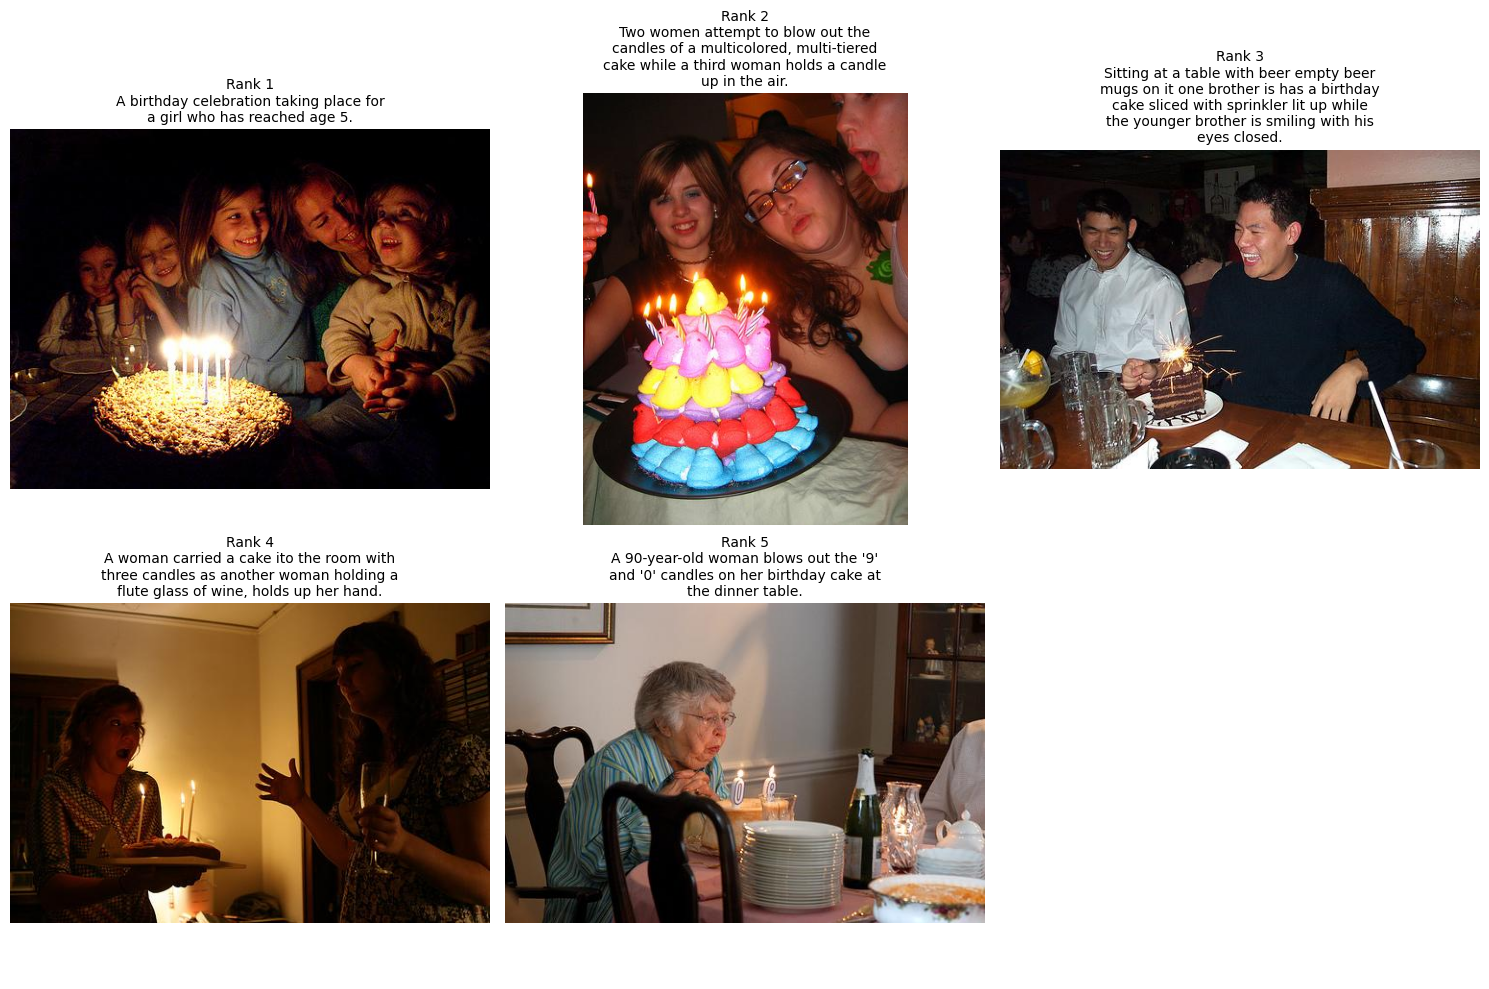

In [16]:
# Example usage for text query
query = "A birthday cake with candles"
top_k = 5

clip_indices = retrieve_images_by_text_return_indices(query, clip_index, clip_image_paths, clip_text_data, clip_model, top_k=top_k)
display_retrieved_images_from_paths(
    indices=clip_indices,
    image_paths=clip_image_paths,
    labels=clip_text_data,
    query_image_path=None,
    query_label=query,
    num_images=top_k
)

### Text from Image Retrieval


🔍 Image Query Results (Top 5):

Rank 1:
   Caption: A baseball player in a red jersey throwing a ball at the pitchers mound.
   Path   : /rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/170292350.jpg
Rank 2:
   Caption: A boy is catching an orange Frisbee in front of a wooden gate.
   Path   : /rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1456630952.jpg
Rank 3:
   Caption: A man in a blue jersey and orange visor threw a frisbee along a grass hill.
   Path   : /rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/194464865.jpg
Rank 4:
   Caption: The boy is wearing a white baseball uniform and holding a baseball.
   Path   : /rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1285067106.jpg
Rank 5:
   Caption: The man in black shorts and a green shirt with the number 25 on the back is about to kick the soccer ball.
   Path   : /rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/146380493.jpg


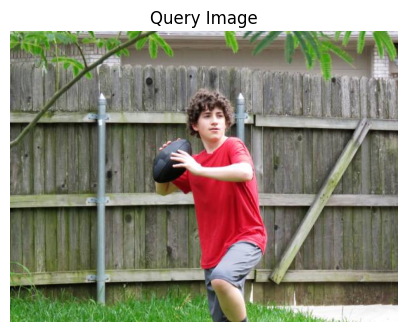

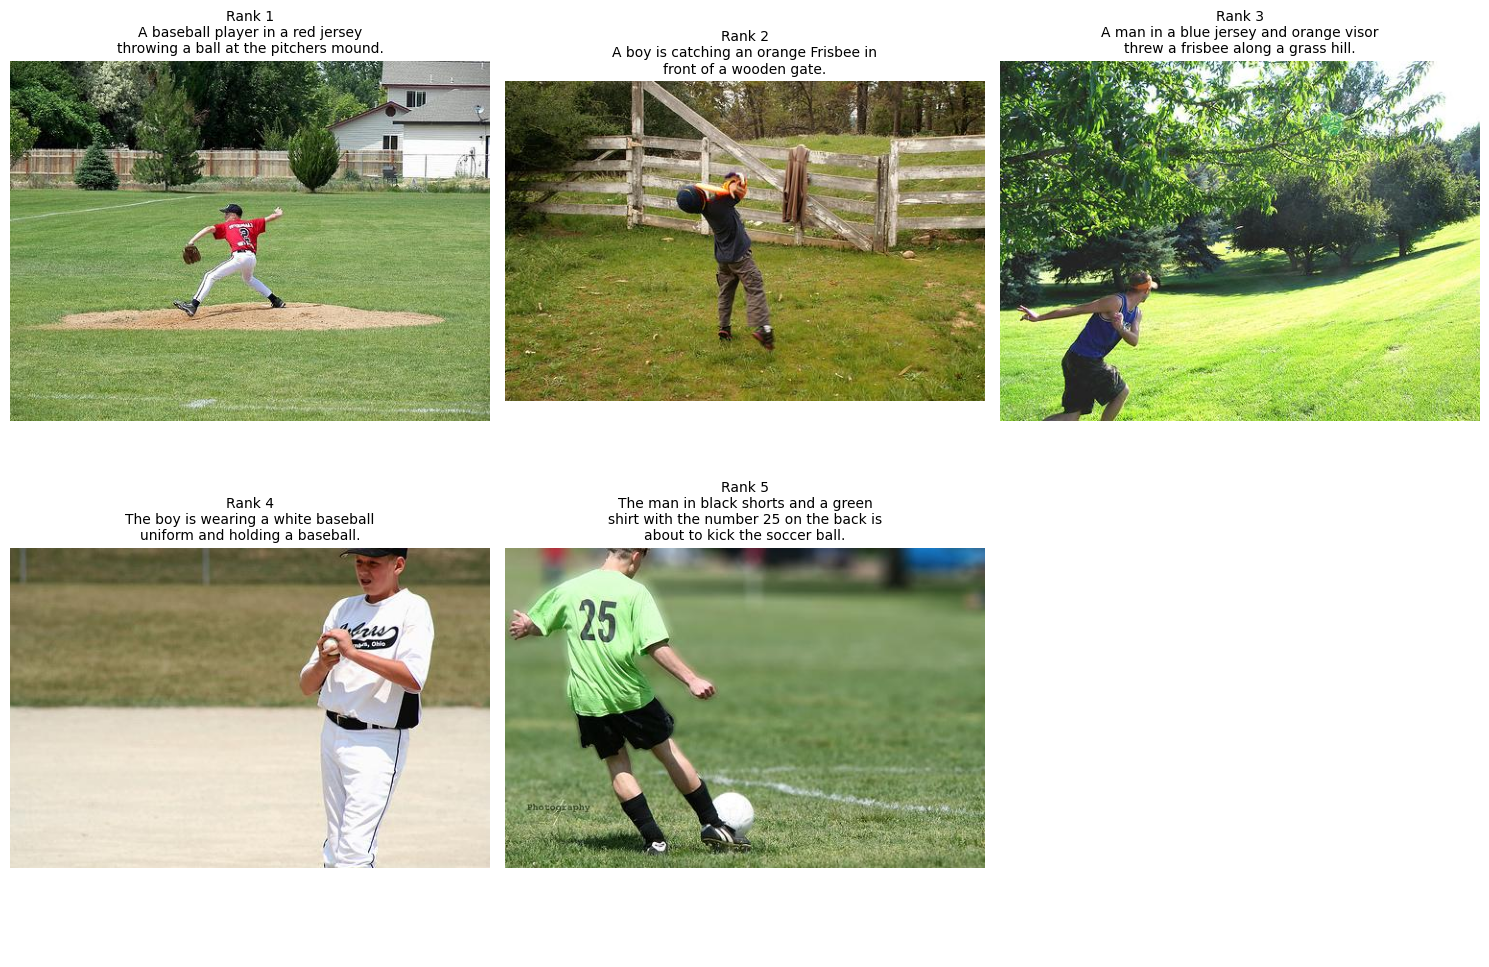

In [17]:
# Example usage for image query

import os

# Find the first valid image path that exists on disk
# sample_image_path = next((p for p in image_paths if p and os.path.exists(p)), None)

# Query Image from the internet
query_image_path = "/rhome/abhar061/shared/adv_ml/project/query_image.jpg"


if query_image_path:
    # Displying query image & the retreived similar images
    result_indices = retrieve_similar_images(query_image_path, clip_model, clip_index, clip_text_data, clip_image_paths, top_k=5)
    display_retrieved_images_from_paths(
        indices=result_indices,
        image_paths=clip_image_paths,
        labels=clip_text_data,
        query_image_path=query_image_path,
        query_label=None,  # No label for input image
        num_images=5
    )
else:
    print("No valid image path found in image_paths.")

## Model Evaluation

### Accuracy Evaluation

In [18]:
# === Step 6: Encode Texts with CLIP ===
print("✍️ Encoding text descriptions...")
# Use the tokenizer from clip_processor
text_tokens = clip_processor.tokenizer(
    clip_text_data, padding=True, truncation=True, return_tensors="pt"
).to(DEVICE)

with torch.no_grad():
    text_embeddings = []
    batch_size = 64
    for i in tqdm(range(0, len(clip_text_data), batch_size)):
        batch = {k: v[i:i + batch_size] for k, v in text_tokens.items()}
        text_feat = clip_model.get_text_features(**batch)
        text_feat /= text_feat.norm(dim=-1, keepdim=True)
        text_embeddings.append(text_feat.cpu().numpy())

text_embeddings = np.concatenate(text_embeddings, axis=0).astype("float32")
assert text_embeddings.shape[0] == clip_image_embeddings.shape[0], "Text and image count mismatch"

# === Step 7: Evaluate Retrieval ===
def evaluate_top_k(text_embeds, index, top_k_percent):
    num_images = index.ntotal
    top_k = max(1, int(num_images * (top_k_percent / 100.0)))
    correct = 0

    print(f"\n🔍 Evaluating Top-{top_k_percent}% Accuracy (Top-{top_k})...\n")

    _, retrieved_indices = index.search(text_embeds, top_k)

    for i, retrieved in enumerate(retrieved_indices):
        if i in retrieved:
            correct += 1

    accuracy = correct / len(text_embeds)
    return accuracy

top1_percent_acc = evaluate_top_k(text_embeddings, clip_index, top_k_percent=1)
top5_percent_acc = evaluate_top_k(text_embeddings, clip_index, top_k_percent=5)

print(f"🎯 Top-1% Accuracy: {top1_percent_acc * 100:.2f}%")
print(f"🎯 Top-5% Accuracy: {top5_percent_acc * 100:.2f}%")

✍️ Encoding text descriptions...


100%|██████████| 63/63 [00:02<00:00, 31.33it/s]



🔍 Evaluating Top-1% Accuracy (Top-40)...


🔍 Evaluating Top-5% Accuracy (Top-200)...

🎯 Top-1% Accuracy: 98.55%
🎯 Top-5% Accuracy: 99.95%


### Top-k Accuracy Plot


🔍 Evaluating Top-1% Accuracy (Top-40)...


🔍 Evaluating Top-2% Accuracy (Top-80)...


🔍 Evaluating Top-3% Accuracy (Top-120)...


🔍 Evaluating Top-4% Accuracy (Top-160)...


🔍 Evaluating Top-5% Accuracy (Top-200)...


🔍 Evaluating Top-6% Accuracy (Top-240)...


🔍 Evaluating Top-7% Accuracy (Top-280)...


🔍 Evaluating Top-8% Accuracy (Top-320)...


🔍 Evaluating Top-9% Accuracy (Top-360)...


🔍 Evaluating Top-10% Accuracy (Top-400)...



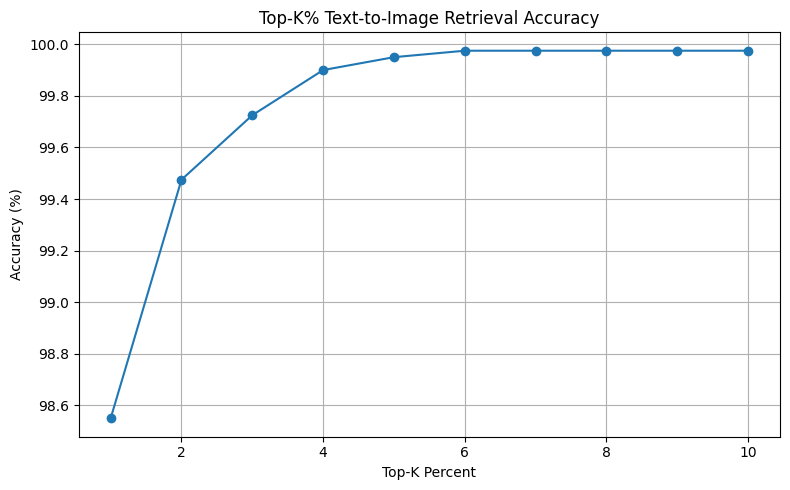

In [19]:
import matplotlib.pyplot as plt

top_k_percents = list(range(1, 11))  # From 1% to 10%
accuracies = []

for k in top_k_percents:
    acc = evaluate_top_k(text_embeddings, clip_index, top_k_percent=k)
    accuracies.append(acc * 100)

plt.figure(figsize=(8, 5))
plt.plot(top_k_percents, accuracies, marker='o')
plt.title("Top-K% Text-to-Image Retrieval Accuracy")
plt.xlabel("Top-K Percent")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Correct Rank Plot

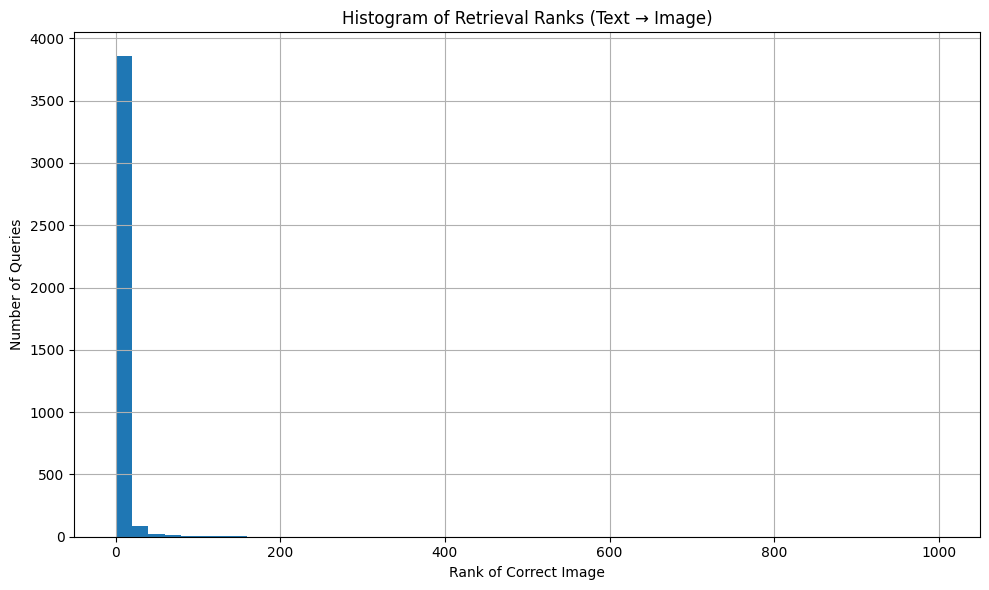

In [20]:
def get_ranks(text_embeddings, index):
    _, I = index.search(text_embeddings, index.ntotal)
    ranks = []
    for i, retrieved in enumerate(I):
        correct_rank = np.where(retrieved == i)[0]
        ranks.append(correct_rank[0] if len(correct_rank) > 0 else index.ntotal)
    return ranks

ranks = get_ranks(text_embeddings, clip_index)

plt.figure(figsize=(10, 6))
plt.hist(ranks, bins=50, range=(0, min(clip_index.ntotal, 1000)))
plt.title("Histogram of Retrieval Ranks (Text → Image)")
plt.xlabel("Rank of Correct Image")
plt.ylabel("Number of Queries")
plt.grid(True)
plt.tight_layout()
plt.show()

### Image & Text Embeddings Comparision Plot

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


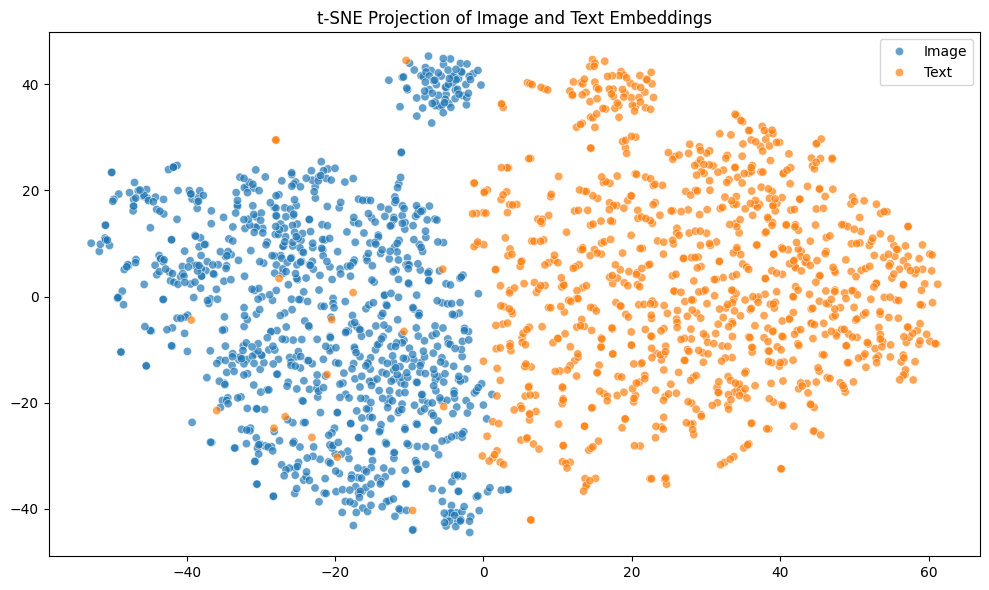

In [32]:
from sklearn.manifold import TSNE
import seaborn as sns

sample_size = 1000
indices = np.random.choice(len(clip_image_embeddings), size=sample_size, replace=False)

# Computing Clip Image Embeddings for random sample
sample_image_embeds = clip_image_embeddings[indices]

# Computing Clip Text Embeddings for random sample
sample_text_tokens = clip_processor.tokenizer(clip_text_data, padding=True, truncation=True, return_tensors="pt").to(DEVICE)
with torch.no_grad():
	sample_text_features = clip_model.get_text_features(**sample_text_tokens).cpu().numpy()
sample_text_embeds = sample_text_features[indices] if sample_text_features.shape[0] > sample_size else np.zeros((sample_size, sample_text_features.shape[1]))


combined = np.vstack((sample_image_embeds, sample_text_embeds))
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(combined)

labels = ["Image"] * sample_size + ["Text"] * sample_size

plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, alpha=0.7)
plt.title("t-SNE Projection of Image and Text Embeddings")
plt.tight_layout()
plt.show()

## LORA

In [47]:
print(list(TaskType))

[<TaskType.SEQ_CLS: 'SEQ_CLS'>, <TaskType.SEQ_2_SEQ_LM: 'SEQ_2_SEQ_LM'>, <TaskType.CAUSAL_LM: 'CAUSAL_LM'>, <TaskType.TOKEN_CLS: 'TOKEN_CLS'>, <TaskType.QUESTION_ANS: 'QUESTION_ANS'>, <TaskType.FEATURE_EXTRACTION: 'FEATURE_EXTRACTION'>]


In [117]:
# Define LoRA configuration
lora_config = LoraConfig(
    r=8,                        # Rank of LoRA matrices (tune for your task)
    lora_alpha=32,              # LoRA scaling parameter
    target_modules=["q_proj", "v_proj"],  # Transformer modules to apply LoRA to (query, value projections)
    task_type=None,
)

# Deep copy for freezing comparison
import copy
original_model = copy.deepcopy(clip_model)

# Wrap the model with LoRA adapters
lora_model = get_peft_model(clip_model, lora_config)

In [120]:
target_modules = []
for name, module in clip_model.named_modules():
    if "proj" in name or "attn" in name:
        target_modules.append(name)

print(len(target_modules), "target modules found in CLIP model")

602 target modules found in CLIP model


There are 602 modules in the CLIP model whose names contain "proj" or "attn". That means there are plenty of candidates for LoRA injection

In [121]:
attn_proj_modules = []
for name, module in clip_model.named_modules():
    if isinstance(module, torch.nn.Linear) and ("attn" in name or "proj" in name):
        attn_proj_modules.append(name)

print(len(attn_proj_modules), "attention and projection modules found in CLIP model")

194 attention and projection modules found in CLIP model


In [122]:
trainable_params = []
for name, param in lora_model.named_parameters():
    if param.requires_grad:
        trainable_params.append(name)
print(f"Total trainable parameters in LoRA model: {len(trainable_params)}")
trainable_params[0]
# As we can see, the LoRA layers are injected into the model. The LoRA layers are named with the prefix "lora_" in the layer names.

Total trainable parameters in LoRA model: 96


'base_model.model.text_model.encoder.layers.0.self_attn.v_proj.lora_A.default.weight'

## Training Loop with Contrastive Loss

In [123]:
import torch
from torch.nn import functional as F
from tqdm import tqdm

# Put LoRA model in training mode
lora_model.train()
optimizer = torch.optim.AdamW(lora_model.parameters(), lr=1e-4)
num_epochs = 5  # adjust based on dataset

for epoch in range(num_epochs):
    total_loss = 0
    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}")

    for images, texts, paths in progress_bar:
        # Step 1: Tokenize with processor
        inputs = clip_processor(images=images, text=texts, return_tensors="pt", padding=True, truncation=True)

        # Step 2: Remove any unsupported keys
        if "inputs_embeds" in inputs:
            del inputs["inputs_embeds"]
        
        # Step 3: Move everything to GPU
        allowed_keys = {"input_ids", "attention_mask", "pixel_values"} # Keep only the safe keys
        model_inputs = {k: v.to(DEVICE) for k, v in inputs.items() if k in allowed_keys}

        # Step 4: Forward pass
        outputs = lora_model(**model_inputs, return_dict=True)

        # Step 5: Compute contrastive loss
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text
        ground_truth = torch.arange(len(images)).to(lora_model.device)

        loss_i2t = F.cross_entropy(logits_per_image, ground_truth)
        loss_t2i = F.cross_entropy(logits_per_text, ground_truth)
        loss = (loss_i2t + loss_t2i) / 2

        # Step 6: Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

    print(f"✅ Epoch {epoch+1} finished. Average Loss: {total_loss / len(loader):.4f}")

Epoch 1: 100%|██████████| 250/250 [00:33<00:00,  7.56it/s, loss=0.0172]  


✅ Epoch 1 finished. Average Loss: 0.1352


Epoch 2: 100%|██████████| 250/250 [00:32<00:00,  7.76it/s, loss=0.0114]  


✅ Epoch 2 finished. Average Loss: 0.0327


Epoch 3: 100%|██████████| 250/250 [00:31<00:00,  7.82it/s, loss=0.00105] 


✅ Epoch 3 finished. Average Loss: 0.0097


Epoch 4: 100%|██████████| 250/250 [00:32<00:00,  7.78it/s, loss=0.000423]


✅ Epoch 4 finished. Average Loss: 0.0033


Epoch 5: 100%|██████████| 250/250 [00:32<00:00,  7.78it/s, loss=0.000258]

✅ Epoch 5 finished. Average Loss: 0.0015


#### Saving the Fine-Tuned LoRA Adapter

In [124]:
lora_model.save_pretrained("clip-lora-flickr30k")

#### Loading the pre-training (before) Model

In [21]:
from peft import PeftModel
lora_model = PeftModel.from_pretrained(clip_model, "clip-lora-flickr30k").to(DEVICE)

## Comparing results after lora Training

#### Creating Image Embeddings for Lora Model

In [22]:
lora_dir = "./image_chunks_lora"
lora_texts, lora_paths, lora_files = create_image_embeddings(
    model=lora_model,
    processor=clip_processor,
    dataloader=loader,
    save_dir=lora_dir,
    chunk_size=2048,
    normalize=True,
    save_images=False  # skips saving images if already available
)

📦 Encoding image embeddings and saving chunks...


Encoding:  51%|█████     | 128/250 [05:32<05:12,  2.56s/it]

💾 Saved chunk 0 with 2048 embeddings


Encoding: 100%|██████████| 250/250 [10:45<00:00,  2.58s/it]

💾 Saved final chunk 1 with 1952 embeddings
✅ All chunks processed and saved.


In [23]:
lora_image_embeddings, lora_text_data, lora_image_paths = load_image_embeddings_from_chunks(lora_dir)

📦 Loaded 4000 texts
🖼️ Loaded 4000 image paths
📊 Loaded 4000 embeddings of dim 512


In [36]:
clip_image_paths

['/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1000092795.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/10002456.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1000268201.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1000344755.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1000366164.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1000523639.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1000919630.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/10010052.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1001465944.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1001545525.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1001573224.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1001633352.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-i

In [37]:
image_save_dir = "/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/"
full_lora_image_paths = [os.path.join(image_save_dir, os.path.basename(p)) for p in lora_image_paths]
full_lora_image_paths

['/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1000092795.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/10002456.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1000268201.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1000344755.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1000366164.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1000523639.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1000919630.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/10010052.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1001465944.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1001545525.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1001573224.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1001633352.jpg',
 '/rhome/abhar061/shared/adv_ml/project/flickr30k-test-i

In [38]:
# Build or load index
lora_index_file = os.path.join(index_dir, "lora.index")

# Creating directory if it doesn't exist
if not os.path.exists(index_dir):
    os.makedirs(index_dir)

# Creating or loading the FAISS index for LoRA embeddings
lora_index = build_or_load_faiss_index(
    embeddings=lora_image_embeddings,
    index_path=lora_index_file,  # auto-creates if doesn't exist
    normalize=True
)

📂 Loading FAISS index from: ./faiss_index/lora.index



🔍 Text Query Results for: "A birthday cake with candles"

Rank 1:
   Caption: A birthday celebration taking place for a girl who has reached age 5.
   Path   : /rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1271210445.jpg
Rank 2:
   Caption: Two women attempt to blow out the candles of a multicolored, multi-tiered cake while a third woman holds a candle up in the air.
   Path   : /rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/2147876139.jpg
Rank 3:
   Caption: Sitting at a table with beer empty beer mugs on it one brother is has a birthday cake sliced with sprinkler lit up while the younger brother is smiling with his eyes closed.
   Path   : /rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/162967671.jpg
Rank 4:
   Caption: A woman carried a cake ito the room with three candles as another woman holding a flute glass of wine, holds up her hand.
   Path   : /rhome/abhar061/shared/adv_ml/project/flickr30k-test-images/1163438830.jpg
Rank 5:
   Caption:

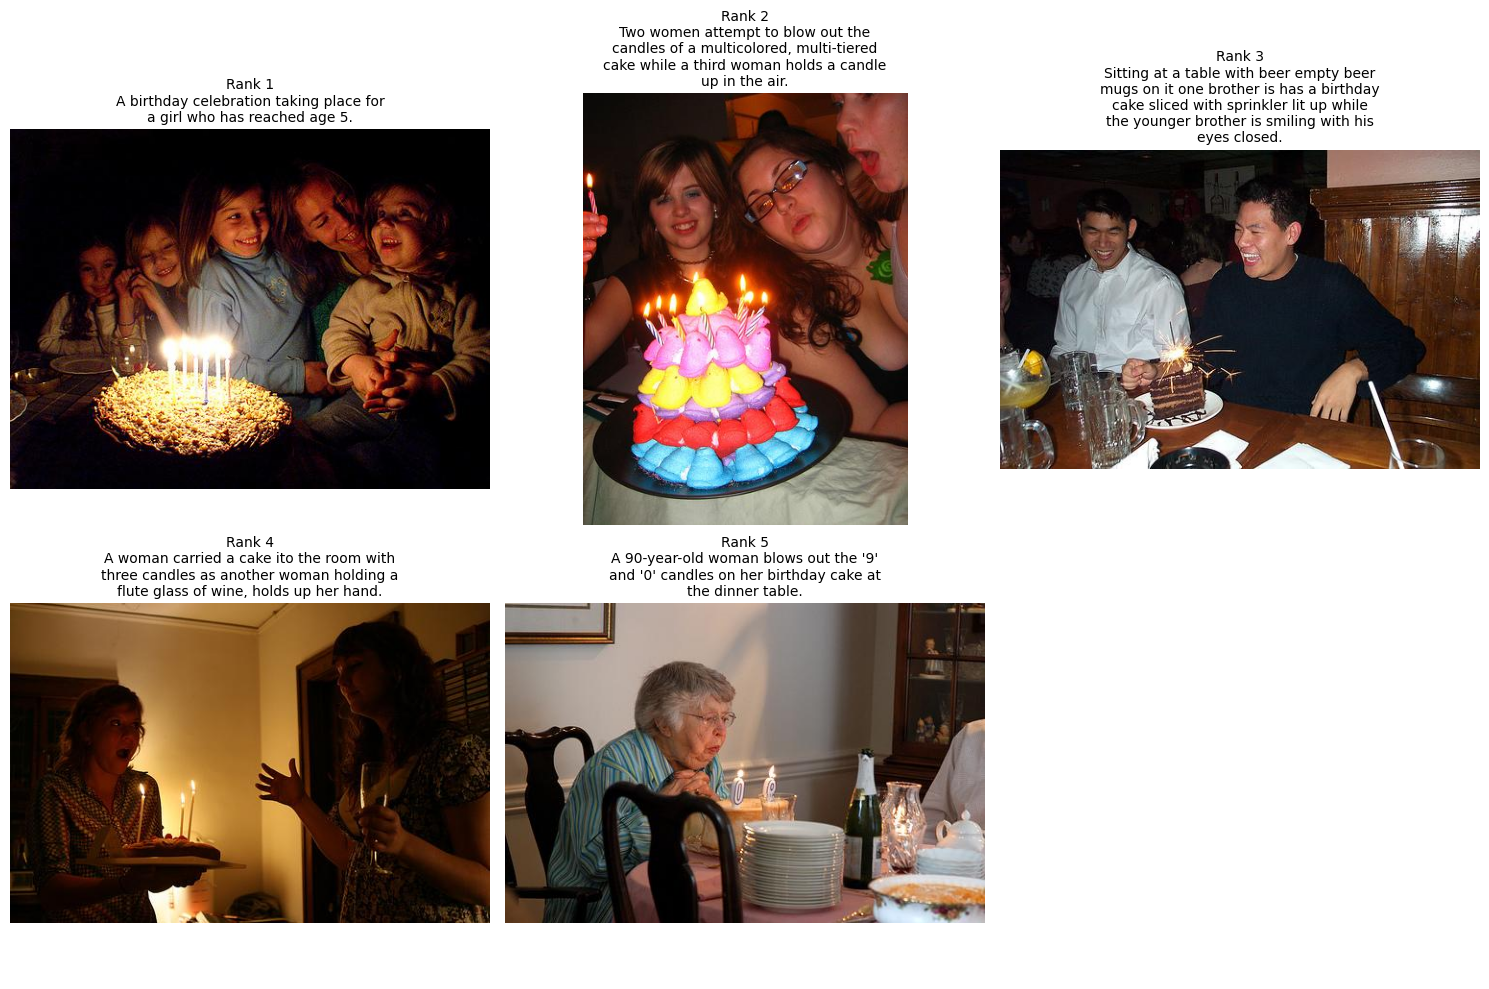

In [39]:
query = "A birthday cake with candles"
indices = retrieve_images_by_text_return_indices(query, index=lora_index, image_paths=full_lora_image_paths, text_data=lora_text_data, clip_model=lora_model, top_k=5)

# Check if there are any valid results before displaying
if indices and indices[0]:
    display_retrieved_images_from_paths(
        indices=indices,
        image_paths=full_lora_image_paths,
        labels=lora_text_data,
        query_image_path=None,
        query_label=query,
        num_images=top_k
    )
else:
    print("❌ No valid results found for the text query.")

#### Freezing vision and text encoders selectively and only training one side.